# Model building

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from zipfile import ZipFile
import os
import sys
limit = None
import itertools

def plot_tsne_with_legends(data, classes):
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(
        data.TSNE1.values, 
        data.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=data.ground_truth
    )
    handles, labels = scatter.legend_elements()
    labels = classes
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.legend(handles, labels)
    plt.title('t-SNE: first 2 components')


def plot_PCA_with_legends(data, classes, y=None):
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(
        data.PC1.values, 
        data.PC2.values, 
        marker='.', 
        linewidths=0.5,
        c=y,
        cmap='viridis',
    )

    handles, labels = scatter.legend_elements()
    labels = classes
    plt.title('PCA: first 2 components')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.legend(handles, labels, fontsize='small' )
    plt.show()


#plot confusion matrix    
def plot_confusion_matrix(cm, classes, model_name):

    plt.figure(figsize=(12,10))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix: '+ model_name, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)
    fmt = ':.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=12,color='black')
    plt.xlabel('Predicted label',fontsize=12,color='black')
    np.set_printoptions(precision=2)
    
    return plt.show()



# Compute confusion matrix
def single_model(model):
    clf = model
    clf.fit(pca_train,ytrain)
    ypred = clf.predict(pca_test)
    conf_mx = confusion_matrix(ypred,ytest, normalize='true')
    return conf_mx


def scale_and_pca(Xtrain, Xtest, n_comp):
    
    ss = StandardScaler()
    Xtrain = pd.DataFrame(ss.fit_transform(Xtrain),
                          columns=Xtrain.columns,
                          index=Xtrain.index)
    Xtest = pd.DataFrame(ss.transform(Xtest),
                          columns=Xtest.columns,
                          index=Xtest.index)
    pca = PCA(n_components=n_comp)
    pca_train = pd.DataFrame(pca.fit_transform(Xtrain),
                          columns = ['PC'+str(i+1) for i in range(n_comp)],
                          index=Xtrain.index)
    pca_test = pd.DataFrame(pca.transform(Xtest),
                          columns = ['PC'+str(i+1) for i in range(n_comp)],
                          index=Xtest.index)
    return pca_train, pca_test, pca


def model_select(classifier):
    cv_result = []
    cv_means = []
    # Cross validate model with Kfold stratified cross val
    kfold = StratifiedKFold(n_splits=5)
    cv_result.append(cross_val_score(classifier, pca_train, y = ytrain, scoring = "accuracy", cv = kfold, n_jobs=4, verbose=2))
    cv_means.append(np.mean(cv_result))
    return cv_means

def plot_PCA(data, y=None):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        data.PC1.values, 
        data.PC2.values, 
        marker='.', 
        linewidths=0.5,
        c=y,
    )
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()

def confusion(y_test, y_hat):
        cm = confusion_matrix(y_test, y_hat)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

        # Bonus: Normalise by row
        sns.heatmap(cm/cm.sum(axis=1, keepdims=True), annot=True, fmt='.3f')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
        
        print(classification_report(y_test, y_hat, digits=3))

def plot_tsne(data):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        data.TSNE1.values, 
        data.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=data.ground_truth
    )
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.title('t-SNE: first 2 components')
#     plt.show()

def plot_coloured_tsne(labels):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(
        labels.TSNE1.values, 
        labels.TSNE2.values, 
        marker='.', 
        linewidths=0.5,
        c=labels.ground_truth,
    )
    plt.show()

def iterate_tsnes(data, n_samples, y=None):
    
    df_ML_50_1 = data.iloc[:n_samples,:]
    params = {
        'learning_rate': [1000],
        'metric': ['euclidean'],
        'n_components': [2],
        'perplexity': [80],
        }
    paramss = list(ParameterGrid(params))
    for param in paramss:        
        tsne = TSNE(
            n_components=2, 
            perplexity=40, 
            verbose=0)
        print (param)
        tsne.set_params(**param)
        digits_tsne = tsne.fit_transform(df_ML_50_1)
        labels = pd.DataFrame()
        labels["TSNE1"] = digits_tsne[:,0]
        labels["TSNE2"] = digits_tsne[:,1]
        labels['ground_truth'] = y[:n_samples]
        plot_tsne_with_legends(labels, classes)
            
            
        
        

def compute_pca(Xtrain, Xtest, classes, n_comp, y=None, return_data=False):
    pca_train, pca_test, pca = scale_and_pca(Xtrain, Xtest, n_comp)
    print("Cumulative variance explained by first {} Principal Components: {}".format(pca.n_components, np.sum(pca.explained_variance_ratio_)))    # df_ML_50 = pca.fit_transform(digits.values)
    pca_df = pd.concat([pca_train,pca_test])
    plot_PCA_with_legends(pca_df,classes, np.concatenate([ytrain,ytest]))
    variance_data(pca)
    loadings = pd.DataFrame(pca.components_, 
                        columns = Xtrain.columns,
                        index = pca_train.columns)
    
    if return_data==True: return pca_train, pca_test, pca_df, loadings


def label_encoder(data, label):
    le = LabelEncoder()
    le.fit(data.loc[:, label].unique())
    response = le.transform(data.loc[:, label])
    featmatrix = data.drop(label, axis=1)
    classes = le.classes_
    return featmatrix, response, classes
    
def clean3(zippath, filenames):
    
    # amino-acid letters
    aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
    
    # files to dataframe
    with ZipFile(zippath, 'r').open(filenames[0]) as file1:
        df_seq = pd.read_csv(file1)        
    with ZipFile(zippath, 'r').open(filenames[1]) as file2:
        df_dup = pd.read_csv(file2)
    
    # merge the dataframes
    df_merge = df_dup.merge(df_seq,how='inner',on='structureId')
    df_merge.rename({'macromoleculeType_x':'macromoleculeType',
                                            'residueCount_y':'residueCount'},axis=1,inplace=True)
    
    # clean the columns
    df_merge.drop(['macromoleculeType_y','residueCount_x'],axis=1,inplace=True)
    df_merge_protein = df_merge[df_merge.macromoleculeType=='Protein']
    df_merge_proteins = df_merge_protein[df_merge_protein.chainId=='A']
    df_merge_proteins2 = df_merge_proteins.drop([
                         'experimentalTechnique',
                         'chainId',
                         'residueCount',
                         'macromoleculeType',
                         'crystallizationMethod',
                         'crystallizationTempK',
                         'densityMatthews',
                         'densityPercentSol',
                         'pdbxDetails',
                        # 'phValue',
                         'publicationYear',
                         'resolution'], axis=1)
    
    
    # drop na
    df_merge_proteins3 = df_merge_proteins2.dropna()
    
    # to identify the top 10 classes
    tab = df_merge_proteins2.classification.value_counts(normalize=True)
    filtered_classes = list(tab.keys()[:10])
    df_merge_proteins4 = df_merge_proteins3[df_merge_proteins3.classification.isin(filtered_classes)]
    
    # to delete unreadable amino-acid letters
    mask = df_merge_proteins4.sequence.apply(lambda x: set(x) <= set(aa))
    df_masked = df_merge_proteins4[mask]
    
    # cleansed sequences to list
    sequences = df_masked.sequence.tolist()
    
    # indexes
    indexes = df_masked.structureId
#     return sequences, indexes
    return df_masked


def variance_data(pca_object):
    # Calculate the explained variance
    exp_var = [i*100 for i in pca_object.explained_variance_ratio_]

    # Calculate the cumulative variance
    cum_var = np.cumsum(pca_object.explained_variance_ratio_*100)

    # Combine both in a data frame
    pca_var = pd.DataFrame(data={'Explained Var': exp_var,
                                 'Cumulative Var': cum_var})
    print(pca_var.head(10))

    # display both the explained and cumulative variance
    fig = plt.figure(figsize=(10,7))

    ax = sns.barplot(
            x = pca_var.index, 
            y = 'Explained Var',  data = pca_var )
    ax.set(
            xlabel = 'Principal Components', 
            ylabel = 'Explained Variance' )

    fig = plt.figure(figsize=(10,7))

    ax = sns.barplot(
            x = pca_var.index, 
            y = 'Cumulative Var',  data = pca_var )
    ax.set(
            xlabel = 'Principal Components', 
            ylabel = 'Cumulative Variance' )
        


# Instructions

Downloads:
1. 11797_16251_bundle_archive.zip (https://www.kaggle.com/shahir/protein-data-set/download do not unpack the zip)
2. descr_kaggledataset_autocorrelation.csv (https://drive.google.com/open?id=1Iz_dMTkL2zm2OKdjKdIJMourV5iqrlFQ) alternatively follow the instructions here (https://github.com/gerry883/capstone) for "Kaggle dataset to csv"

place them in the same folder.

set the path containing the two files as current directory

create a python 3 env installing sklearn

### base dataframe to work on

In [2]:
zip_file = "11797_16251_bundle_archive.zip"
file_list = ['pdb_data_seq.csv','pdb_data_no_dups.csv']

df_masked = clean3(zip_file, file_list)

path = r"C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_kaggledataset_autocorrelation.csv"

df_descriptors = pd.read_csv(path)

df_ML = pd.merge(df_masked, df_descriptors, how='inner')

print(df_ML.shape)

print(df_ML.isnull().sum().value_counts())

print(df_ML.columns[:4])

(55867, 725)
0    725
dtype: int64
Index(['structureId', 'classification', 'structureMolecularWeight', 'phValue'], dtype='object')


### Train and test sets

In [3]:
X, y, classes = label_encoder(df_ML,'classification')
print(y)
X1 = X.drop(['structureId','structureMolecularWeight','phValue','sequence'], axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y, test_size=0.2, random_state=123, stratify=y)

[0 0 0 ... 6 8 5]


### PCA

Cumulative variance explained by first 81 Principal Components: 0.8020113516878461


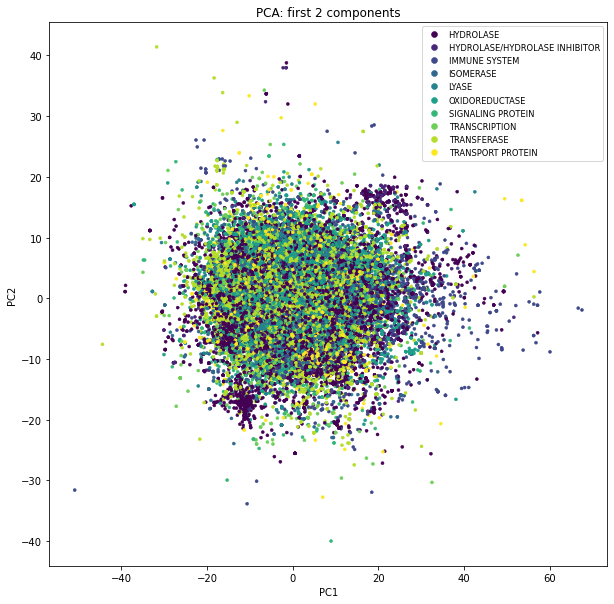

   Explained Var  Cumulative Var
0      14.685377       14.685377
1       5.882891       20.568268
2       4.343530       24.911798
3       3.681844       28.593642
4       3.128622       31.722264
5       3.003255       34.725519
6       2.445935       37.171455
7       1.752706       38.924161
8       1.435531       40.359692
9       1.337154       41.696847


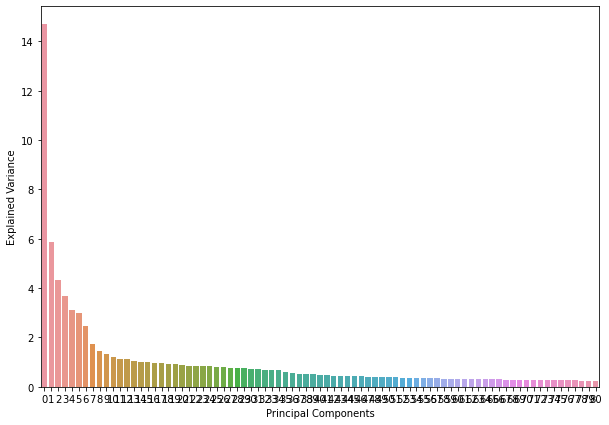

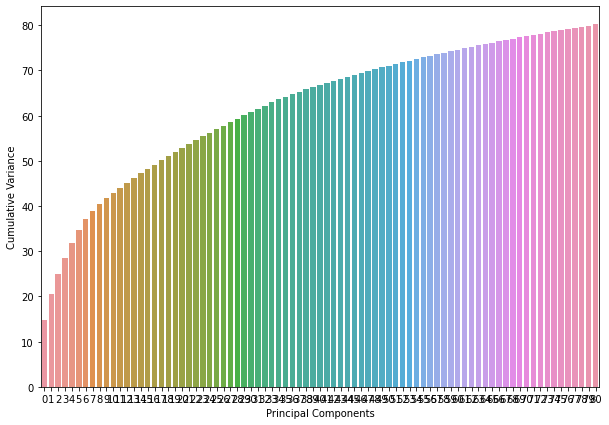

In [122]:
# PCA with 81 components
pca_train, pca_test, pca_df, loadings = compute_pca(Xtrain, Xtest, classes, 81, y, return_data=True)


To plot first pca loadings

In [5]:
loadings.iloc[0:1,:].transpose().sort_values('PC1',ascending=False).head(5)

,PC1
GearyAuto_Steric7,0.092990
GearyAuto_Steric2,0.092921
GearyAuto_Steric8,0.092920
GearyAuto_Steric6,0.092803
GearyAuto_ResidueASA30,0.092686


In [6]:
loadings.iloc[1:2,:].transpose().sort_values('PC2',ascending=False).head(5)

,PC2
GearyAuto_ResidueVol13,0.116454
MoreauBrotoAuto_Mutability10,0.108937
GearyAuto_Mutability7,0.044420
MoranAuto_ResidueASA19,0.044318
GearyAuto_ResidueASA9,0.044297


In [7]:
loadings.iloc[2:3,:].transpose().sort_values('PC3',ascending=False).head(5)

,PC3
MoreauBrotoAuto_ResidueASA18,0.139425
MoreauBrotoAuto_Steric28,0.138851
MoranAuto_Hydrophobicity16,0.138790
MoranAuto_Steric25,0.138585
MoranAuto_Steric22,0.138339


#### t-SNE

{'learning_rate': 1000, 'metric': 'euclidean', 'n_components': 2, 'perplexity': 80}


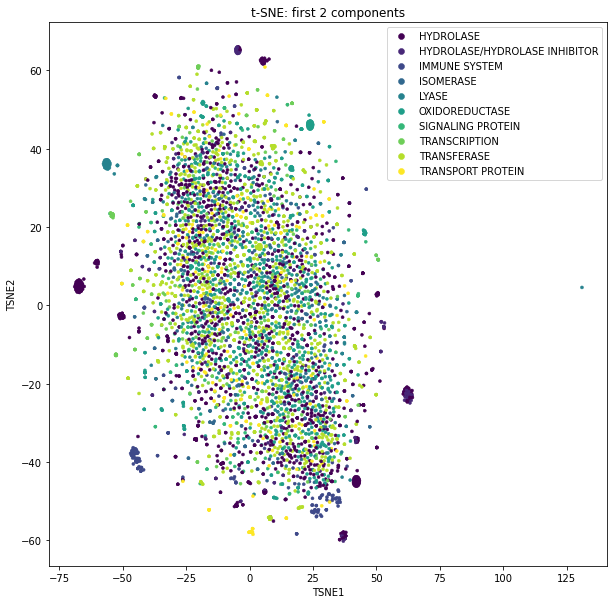

In [125]:
iterate_tsnes(pca_df, 5000, np.concatenate([ytrain,ytest]))

### Model selection

In [9]:
# Fitting all the models 
model_type = [KNeighborsClassifier(),GaussianNB(),RandomForestClassifier(),
              AdaBoostClassifier(),GradientBoostingClassifier(),DecisionTreeClassifier(),ExtraTreesClassifier()]
model_score = [model_select(i) for i in model_type]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 50.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

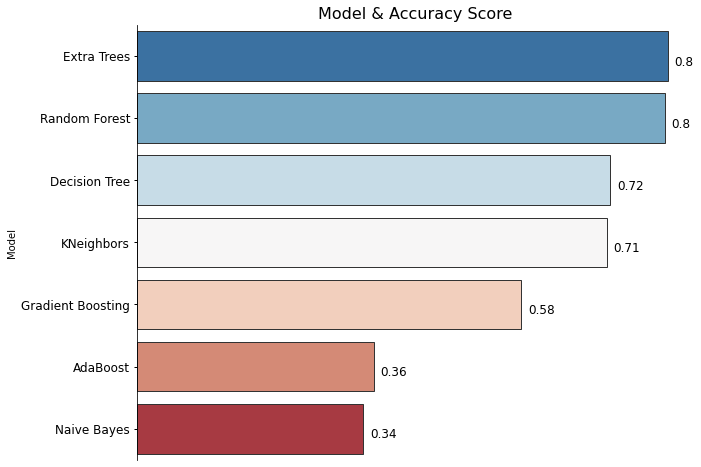

In [10]:
classifier = ['KNeighbors','Naive Bayes','Random Forest', 
             'AdaBoost','Gradient Boosting','Decision Tree','Extra Trees']
# Place result in a data Frame
ml_model = pd.DataFrame(model_score, classifier).reset_index()
ml_model.columns=['Model','acc_score']
ml_model.sort_values('acc_score',ascending = False,inplace=True)
ml_model.reset_index(drop=True,inplace = True)
f, ax = plt.subplots(figsize=(10,8))
sns.barplot('acc_score','Model',data=ml_model, ax=ax,palette='RdBu_r',edgecolor=".2")
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black') 
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title('Model & Accuracy Score',fontsize=16)
sns.despine(bottom=True)
plt.show()

In [147]:
def plot_confusion_matrix(cm, classes, model_name):

    plt.figure(figsize=(12,10))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix: '+ model_name, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)
    fmt = '^-03.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=12,color='black')
    plt.xlabel('Predicted label',fontsize=12,color='black')
    np.set_printoptions(precision=2)
    
    return plt.show()


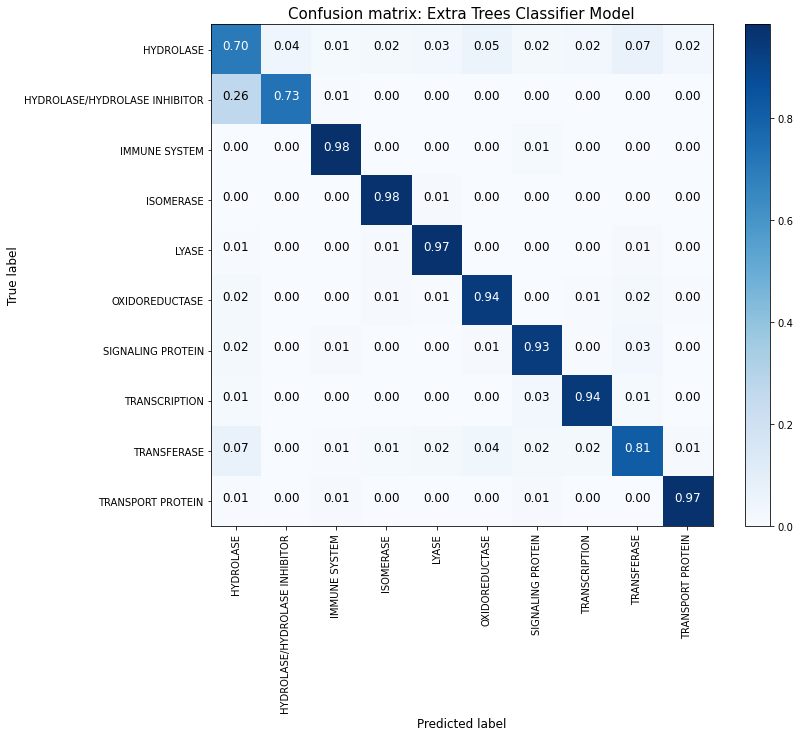

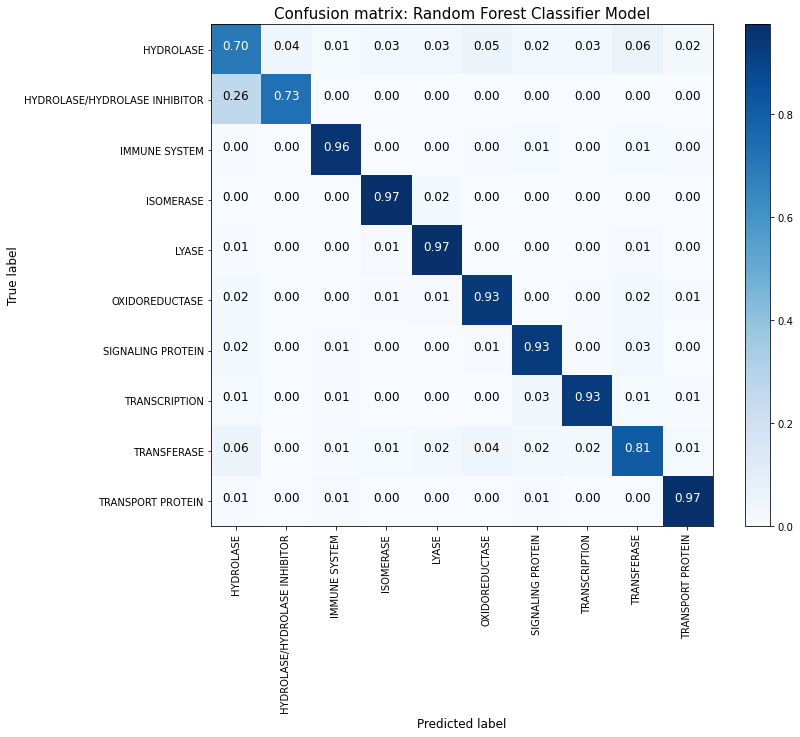

In [148]:
plot_confusion_matrix(single_model(ExtraTreesClassifier()), classes,'Extra Trees Classifier Model')
plot_confusion_matrix(single_model(RandomForestClassifier()), classes,'Random Forest Classifier Model')
#plot_confusion_matrix(single_model(SVC()), classes,'Support Vector Classifier Model')

In [20]:
def scale_and_pca2(Xtrain, n_comp):
    
    ss = StandardScaler()
    Xtrain = pd.DataFrame(ss.fit_transform(Xtrain),
                          columns=Xtrain.columns,
                          index=Xtrain.index)
    pca = PCA(n_components=n_comp)
    pca_train = pd.DataFrame(pca.fit_transform(Xtrain),
                          columns = ['PC'+str(i+1) for i in range(n_comp)],
                          index=Xtrain.index)
    
    return pca_train, pca

XX, pca2 = scale_and_pca2(X2, 81)

In [22]:
X2 = pd.read_csv(r'C:\Users\Gerardo\ADB\Capstone\PyBioMed-1.0\descr_human_proteome_autocorrelation.csv', index_col='ID')
et = ExtraTreesClassifier().fit(pca_train,ytrain)
XX, pca2 = scale_and_pca2(X2, 81)
ypred = et.predict(XX)


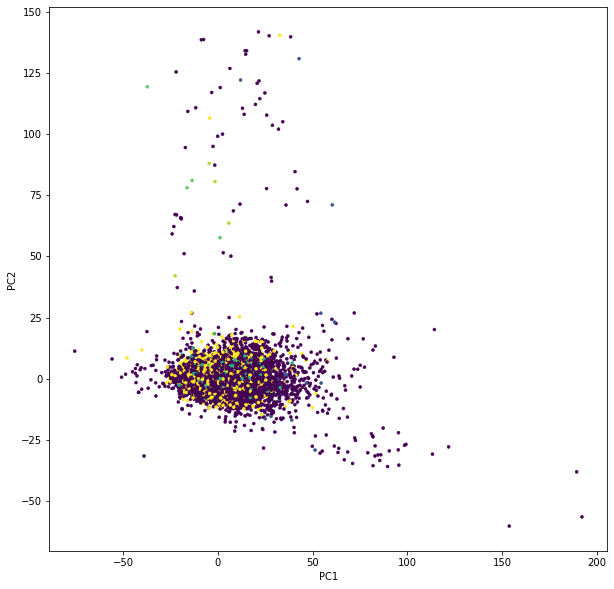

In [23]:
plot_PCA(XX, ypred)